## SAC_Pendulum-v1

SAC（Soft Actor-Critic）有两个版本，其中[SAC-v1](https://arxiv.org/abs/1801.01290)由Haarnoja等人于2018年提出，也是该算法的最初版本, [SAC-v2](https://arxiv.org/abs/1812.05905)则是于2019年提出的改进版本。其中相比于v1版本，SAC-v2主要做了两项重要改进，一是移除了Value网络，二是引入了自动调节entropy系数 $\alpha$。

由于目前主流使用的是V2版本，因此未特别说明的情况下，我们默认实现v2版本, 例如本Notebook。相比v1版本，v2版本主要去掉了Value网络，以及使用的双Q(cirtic)网络。

v1版本中Value网络主要充当Actor 和 Critic 网络训练之间的桥梁，但是增加一个这样的网络会导致更多误差传播路径，并且其实可以这样构造Q的目标函数，更稳定更直接：

$$
r+\gamma \cdot\left(\min \left(Q_1^{\prime}, Q_2^{\prime}\right)-\alpha \log \pi\left(a^{\prime} \mid s^{\prime}\right)\right)
$$

而双Q网络的作用，就跟Double DQN、TD3算法类似，多一个critic来减缓Q值的过估计。


### 定义参数

为方便实验调试，把所有参数都放在一起

In [28]:
import torch

class Config:
    def __init__(self):
        self.algo_name = 'SAC'
        self.env_id = 'Pendulum-v1'
        self.mode = 'train'
        self.seed = 0 # 随机种子
        self.max_epsiode = 100 # 训练的回合数
        self.max_step = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        #region 在线测试相关参数
        self.online_eval_episode = 10 # 测试的回合数
        self.online_eval_freq = 2000 # 在线测试的频率, 模型每更新N次就测试一次
        #endregion
        self.gamma = 0.99 #折扣因子
        self.lambda_mean=1e-3 # 重参数化分布均值的损失权重
        self.lambda_std=1e-3 # 重参数化分布标准差的损失权重
        self.lambda_z = 0.0 # 重参数化分布抽样值的损失权重
        self.soft_update_tau = 1e-2 # 目标网络软更新系数
        self.lr_critic = 3e-4 # Q网络的学习率
        self.lr_actor = 3e-4 # 策略网络的学习率
        self.lr_alpha = 3e-4 # 温度参数的学习率
        self.buffer_size = 100000 # 经验回放池大小
        self.hidden_dim = 256 # 隐藏层维度
        self.batch_size  = 256 # 批次大小
        self.device = self._auto_get_device() # 设备
    
    def _auto_get_device(self):
        _device = 'cpu'
        if torch.cuda.is_available():
            _device = 'cuda'
        elif torch.backends.mps.is_available():
            _device = 'mps'
        return _device

### 定义模型

去掉了Value网络之后，SAC-v2版本就是一个经典的Actor-Critic结构了。

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal
import numpy as np

        
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, init_w=3e-3):
        super(Critic, self).__init__()
        '''SoftQ
        '''
        self.linear1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        # 初始化权重
        self.mean_linear = nn.Linear(hidden_dim, action_dim)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_dim, action_dim)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mean, std
    
    def sample(self, state):
        mean, std = self.forward(state)
        normal = Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)
        # 计算log_prob
        # 这里的log_prob是对z的log_prob
        # 需要对z进行重参数化
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

### 定义经验回放

经验回放主要有两个功能，一是存储样本(push)，二是随时采样样本(sample)。

In [30]:
from collections import deque
import random

class ReplayBuffer(object):
    def __init__(self, cfg: Config) -> None:
        self.capacity = cfg.buffer_size
        self.buffer = deque(maxlen=self.capacity)
        
    def push(self, transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)

    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
        
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 定义策略

SAC-v1 的value网络包含主网络和目标网络，起作用跟`DQN`中的 $Q$ 和 $Q_target$ 网络是一样的，都是为了避免估计目标Q值的剧烈波动，使得训练更加稳定。

In [31]:
class Policy:
    def __init__(self, cfg: Config, state_dim:int, action_dim:int) -> None:

        self.batch_size  = cfg.batch_size 
        
        self.device = torch.device(cfg.device)
        self.gamma = cfg.gamma
        self.lambda_mean = cfg.lambda_mean
        self.lambda_std  = cfg.lambda_std
        self.lambda_z    = cfg.lambda_z
        self.soft_update_tau = cfg.soft_update_tau

        # 双Q网络
        self.critic_1 = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.critic_2 = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.critic_1_target = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.critic_2_target = Critic(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())

        self.actor = Actor(state_dim, action_dim, cfg.hidden_dim).to(self.device)  

        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)

        self.opt_critic_1 = Adam(self.critic_1.parameters(), lr=cfg.lr_critic)
        self.opt_critic_2 = Adam(self.critic_2.parameters(), lr=cfg.lr_critic)
        self.opt_actor = Adam(self.actor.parameters(), lr=cfg.lr_actor)  
        self.opt_alpha = Adam([self.log_alpha], lr=cfg.lr_alpha) # 学习率和actor相同

        self.target_entropy = -action_dim # 目标熵

        self.memory = ReplayBuffer(cfg)

        self.update_cnt = 0

    def sample_action(self, state):
        return self.predict_action(state)
    
    @torch.no_grad()
    def predict_action(self, state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        mean, log_std = self.actor.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z)
        action = action.detach().cpu().numpy()
        return action[0]
    
    def get_policy_params(self):
        '''获取策略网络的参数
        '''
        return self.actor.parameters()
    
    def set_policy_params(self, params):
        '''设置策略网络的参数
        '''
        for param, new_param in zip(self.actor.parameters(), params):
            param.data.copy_(new_param.data)
        
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return 
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size) # 从经验回放中随机采样一个批量的转移(transition)
        # 将数据转换为tensor
        states = torch.tensor(np.array(states), device = self.device, dtype=torch.float) # [B, state_dim]
        actions = torch.tensor(np.array(actions), device=self.device,  dtype = torch.float)  #  [B, 1]
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float).unsqueeze(1)   # [B, 1]
        next_states = torch.tensor(np.array(next_states), device=self.device, dtype=torch.float) # [batchB_size, state_dim]
        dones = torch.tensor(np.float32(dones), device=self.device).unsqueeze(1)  # [batch_size,1]

        with torch.no_grad():
            actions_next, log_probs_next = self.actor.sample(next_states) #计算t+1时刻的动作
            q_value_1_target = self.critic_1_target(next_states, actions_next) #计算t+1时刻的q值
            q_value_2_target = self.critic_2_target(next_states, actions_next)
            q_value_min = torch.min(q_value_1_target, q_value_2_target) # 计算t+1时刻的q值
            alpha = self.log_alpha.exp() # 计算温度参数
            q_value_target = rewards + (1 - dones) * self.gamma * (q_value_min - alpha * log_probs_next) # 计算t+1时刻的q值
        
        q_value_1 = self.critic_1(states, actions) #计算t时刻的q值
        q_value_2 = self.critic_2(states, actions)

        loss_critic_1 = nn.MSELoss()(q_value_1, q_value_target) #计算q网络的损失函数
        loss_critic_2 = nn.MSELoss()(q_value_2, q_value_target)

        self.opt_critic_1.zero_grad()
        loss_critic_1.backward()
        self.opt_critic_1.step()

        self.opt_critic_2.zero_grad()
        loss_critic_2.backward()
        self.opt_critic_2.step()

        actions_new, log_probs_new = self.actor.sample(states) #计算t时刻的动作
        q_value_new = torch.min(self.critic_1(states, actions_new), self.critic_2(states, actions_new)) #计算t时刻的q值
        loss_actor = (alpha * log_probs_new - q_value_new).mean() #计算策略网络的损失函数
        self.opt_actor.zero_grad()
        loss_actor.backward()
        self.opt_actor.step()
        
        loss_alpha = -(self.log_alpha * (log_probs_new + self.target_entropy).detach()).mean()
        self.opt_alpha.zero_grad()
        loss_alpha.backward()
        self.opt_alpha.step()
        self.log_alpha.data = self.log_alpha.data.clamp(-20, 2) # 限制温度参数的范围
        ## 软更新目标值网络参数
        for target_param, param in zip(self.critic_1_target.parameters(), self.critic_1.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_update_tau) + param.data * self.soft_update_tau
            )
        for target_param, param in zip(self.critic_2_target.parameters(), self.critic_2.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_update_tau) + param.data * self.soft_update_tau
            )
        self.update_cnt += 1
        return {'loss_critic_1': loss_critic_1.item(),
                'loss_critic_2': loss_critic_2.item(),
                'loss_actor': loss_actor.item(),
                'loss_alpha': loss_alpha.item()}
    


### 定义可视化函数

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_curve(cfg: Config, frames: list, rewards : list, label:str = "rewards", title:str = None):
    ''' 画图
    '''
    if title is None:
        title = f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}"
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(title)
    plt.xlabel('frames')
    plt.plot(frames, rewards, label=f"{label}")
    plt.plot(frames, smooth(rewards), label=f"{label}_smoothed")
    plt.legend()
    plt.show()

def print_cfgs(cfg: Config):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    allow_types = ['int', 'float', 'str', 'bool', 'list', 'dict']
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        if v.__class__.__name__ not in allow_types:
            continue
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  



### 定义环境

In [33]:
import gymnasium as gym

class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        return action
    
class EnvMgr:
    def __init__(self, cfg: Config):
        self.env = gym.make(cfg.env_id) # 创建环境
        self.env = NormalizedActions(self.env) # 归一化动作空间
        self.eval_env = gym.make(cfg.env_id)
        self.eval_env = NormalizedActions(self.eval_env)
        print(f"env id: {cfg.env_id}, state_dim: {self.state_dim}, action_dim: {self.action_dim}")
    @property
    def action_dim(self):
        return self.env.action_space.shape[0] # 动作空间的维度
    @property
    def state_dim(self):
        return self.env.observation_space.shape[0]

## 2.模型训练与测试

In [ ]:

def eval_policy(cfg: Config, policy: Policy, env):
    ''' 测试
    '''
    rewards = []  # 记录所有回合的奖励
    steps = []  # 记录所有回合的步数
    for _ in range(cfg.online_eval_episode):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, _ = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            action = policy.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            ep_step += 1
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        steps.append(ep_step)
    
    return {'reward': np.mean(rewards), 'step': np.mean(steps)}

def train(cfg: Config, policy: Policy, env_mgr: EnvMgr):
    ''' 训练
    '''
    env = env_mgr.env
    eval_env = env_mgr.eval_env
    rewards = []  # 记录所有回合的奖励
    eval_rewards = []  # 记录所有回合的奖励
    best_policy_params = None  # 最佳策略
    best_ep_reward = float('-inf') # 最佳回合的奖励
    tot_step = 0
    policy_summary_dict = {} # 记录策略更新的参数，如损失等
    for i_ep in range(cfg.max_epsiode):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, _ = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            ep_step += 1
            tot_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , _ = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, terminated or truncated))  # 保存transition
            state = next_state  # 更新下一个状态
            # 更新智能体，这里也可以改成每采样50步再更新50次
            policy_summary = policy.update()  
            if policy_summary is not None:
                for k, v in policy_summary.items():
                    if k not in policy_summary_dict:
                        policy_summary_dict[k] = []
                    policy_summary_dict[k].append(v)
                if policy.update_cnt > 0 and policy.update_cnt % cfg.online_eval_freq == 0:
                    eval_res = eval_policy(cfg, policy, eval_env)
                    eval_rewards.append(eval_res['reward'])
                    if eval_res['reward'] >= best_ep_reward:
                        print(f"找到新的最优策略，回合：{i_ep+1}，模型步数：{policy.update_cnt}，测试奖励：{eval_res['reward']:.2f}, 测试回合长度：{eval_res['step']}")
                        best_ep_reward = eval_res['reward']
                        best_policy_params = policy.get_policy_params()
            # policy.update() 
            ep_reward += reward  # 累加奖励
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.max_epsiode}，奖励：{ep_reward:.2f}，回合长度：{ep_step}")
    env.close()
    return {'rewards':rewards, 'eval_rewards':eval_rewards, 'policy_summary_dict':policy_summary_dict,'best_policy_params':best_policy_params}


In [35]:

# 获取参数
cfg = Config() 
env_mgr = EnvMgr(cfg) # 创建环境
policy = Policy(cfg, env_mgr.state_dim, env_mgr.action_dim) # 创建策略
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg, policy, env_mgr) # 训练


env id: Pendulum-v1, state_dim: 3, action_dim: 1
Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        SAC         	   <class 'str'>    
       env_id       	    Pendulum-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         0          	   <class 'int'>    
    max_epsiode     	        100         	   <class 'int'>    
      max_step      	        200         	   <class 'int'>    
online_eval_episode 	         10         	   <class 'int'>    
  online_eval_freq  	        2000        	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
    lambda_mean     	       0.001        	  <class 'float'>   
     lambda_std     	       0.001        	  <class 'float'>   
      lambda_z      	        0.0         	  <class 'float'>   
  soft_update_tau   	        0.01        	  <class 'float'>   
     lr_critic      	       0.0003       	  <class '

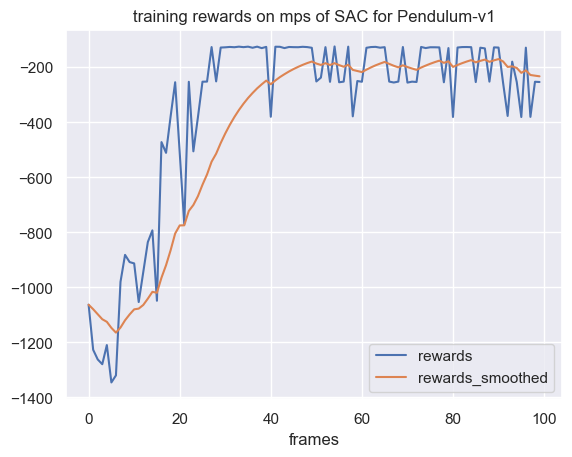

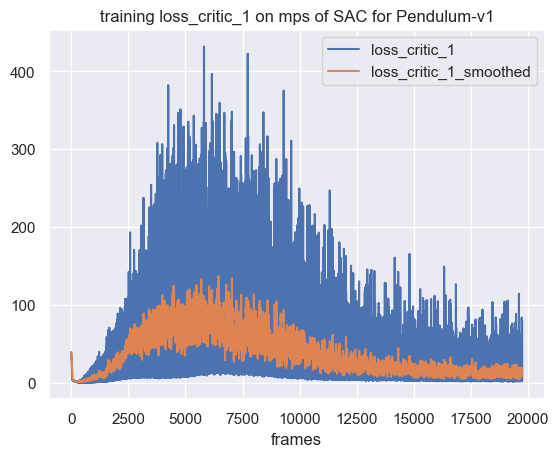

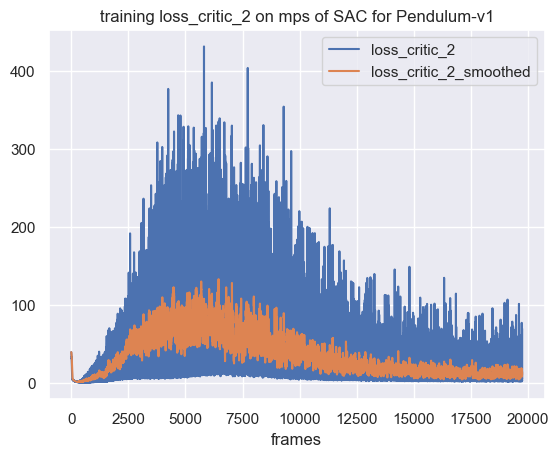

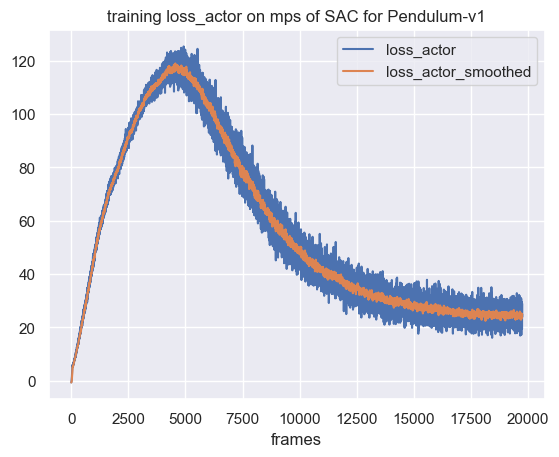

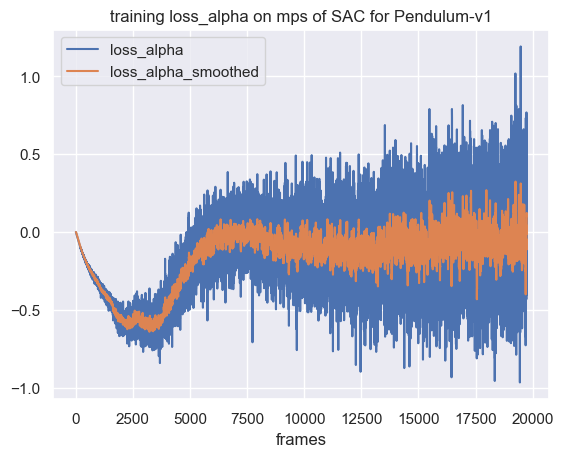

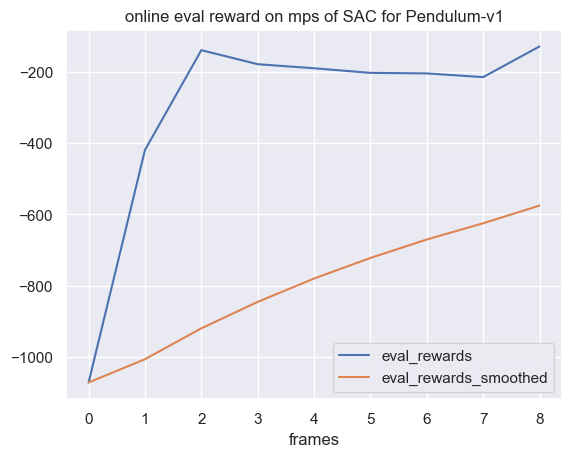

In [36]:
plot_curve(cfg, range(len(res['rewards'])), res['rewards'], label = "rewards", title = f"{cfg.mode}ing rewards on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
for k, v in res['policy_summary_dict'].items():
    plot_curve(cfg, range(len(v)), v, label = k, title = f"{cfg.mode}ing {k} on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
plot_curve(cfg, range(len(res['eval_rewards'])), res['eval_rewards'], label = "eval_rewards", title = f"online eval reward on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")